# 1. Developing and Saving the Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import product
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import os
import pandas as pd
import segmentation_models_pytorch as smp

/apps/pytorch/2.2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PRECOMPUTED_DATA_ROOT = r"Data"

class PrecomputedNoise2NoiseDataset(Dataset):
    def __init__(self, manifest_file, root_dir):
        self.root_dir = root_dir
        try:
            self.manifest = pd.read_csv(manifest_file)
        except FileNotFoundError:
            print(f"Error: Manifest file not found at {manifest_file}")
            print("Please ensure you have run the data generation phase first.")
            self.manifest = pd.DataFrame() # Empty dataframe

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        if idx >= len(self.manifest):
            raise IndexError("Index out of bounds")
            
        record = self.manifest.iloc[idx]
        
        noisy1_path = os.path.join(self.root_dir, record['noisy1_path'])
        noisy2_path = os.path.join(self.root_dir, record['noisy2_path'])
        clean_path = os.path.join(self.root_dir, record['clean_path'])

        time_step = record['time_step']
        config_name = record['config_name']

        try:
            noisy1_tensor = torch.load(noisy1_path)
            noisy2_tensor = torch.load(noisy2_path)
            clean_tensor = torch.load(clean_path)
        except FileNotFoundError as e:
            print(f"Error loading file for sample id {record['id']}: {e}")
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            # Return dummy metadata as well, or handle appropriately
            return dummy_tensor, dummy_tensor, dummy_tensor, 0.0, "error_config" 
        except Exception as e:
            print(f"Generic error loading file for sample id {record['id']}: {e}")
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            return dummy_tensor, dummy_tensor, dummy_tensor, 0.0, "error_config"

        # Return tensors and the new metadata
        return noisy1_tensor, noisy2_tensor, clean_tensor, time_step, config_name

In [3]:
manifest_path = os.path.join(PRECOMPUTED_DATA_ROOT, 'manifest.csv')

if not os.path.exists(manifest_path):
    print(f"Manifest file {manifest_path} not found. Please run the data generation phase first.")
    
full_dataset = PrecomputedNoise2NoiseDataset(manifest_file=manifest_path, root_dir=PRECOMPUTED_DATA_ROOT)

train_loader, val_loader, test_loader = None, None, None

if len(full_dataset) > 0:
    total_samples = len(full_dataset)
    indices = list(range(total_samples))
    np.random.shuffle(indices)

    train_ratio = 0.7
    val_ratio = 0.15
    # test_ratio = 0.15 implicitly

    if total_samples < 3:
        train_indices = indices
        val_indices, test_indices = [],[]
    else:
        train_split_idx = int(train_ratio * total_samples)
        val_split_idx = train_split_idx + int(val_ratio * total_samples)
        
        train_indices = indices[:train_split_idx]
        val_indices = indices[train_split_idx:val_split_idx]
        test_indices = indices[val_split_idx:]

        # Ensure all sets have at least one sample if total_samples allows
        if not test_indices and val_indices: test_indices = val_indices[-1:]; val_indices = val_indices[:-1]
        if not val_indices and train_indices: val_indices = train_indices[-1:]; train_indices = train_indices[:-1]


    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)
    test_subset = Subset(full_dataset, test_indices)

    print(f"Total precomputed samples: {total_samples}")
    print(f"Train samples: {len(train_subset)}")
    print(f"Validation samples: {len(val_subset)}")
    print(f"Test samples: {len(test_subset)}")
    
    BATCH_SIZE = 1 # Keep batch size small for 1500x1500 images
    if len(train_subset) > 0:
        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    if len(val_subset) > 0:
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    if len(test_subset) > 0:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

else:
    print("Full dataset is empty. Cannot create data loaders.")

Total precomputed samples: 240
Train samples: 168
Validation samples: 36
Test samples: 36


Using device: cuda


/scratch/local/4428790/ipykernel_1388747/3477283225.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))
/scratch/local/4428790/ipykernel_1388747/3477283225.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):



Starting training...

--- Epoch 1/5 ---
Tr B 0/168, Loss: 2.1310
Tr B 10/168, Loss: 1.7034
Tr B 20/168, Loss: 1.3760
Tr B 30/168, Loss: 1.3888
Tr B 40/168, Loss: 1.3744
Tr B 50/168, Loss: 1.3449
Tr B 60/168, Loss: 1.3734
Tr B 70/168, Loss: 1.3513
Tr B 80/168, Loss: 1.3289
Tr B 90/168, Loss: 1.4988
Tr B 100/168, Loss: 1.4180
Tr B 110/168, Loss: 1.3420
Tr B 120/168, Loss: 1.3452
Tr B 130/168, Loss: 1.3463
Tr B 140/168, Loss: 1.3276
Tr B 150/168, Loss: 1.3557
Tr B 160/168, Loss: 1.3454
End Epoch Train Avg Loss: 1.4085


/scratch/local/4428790/ipykernel_1388747/3477283225.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Val Avg Loss: 1.3508
Saved new best model (val_loss: 1.3508) to best_denoising_model_mse_loss.pth

--- Epoch 2/5 ---
Tr B 0/168, Loss: 1.3521
Tr B 10/168, Loss: 1.3800
Tr B 20/168, Loss: 1.3498
Tr B 30/168, Loss: 1.3114
Tr B 40/168, Loss: 1.2759
Tr B 50/168, Loss: 1.3306
Tr B 60/168, Loss: 1.3228
Tr B 70/168, Loss: 1.3223
Tr B 80/168, Loss: 1.3624
Tr B 90/168, Loss: 1.3737
Tr B 100/168, Loss: 1.3183
Tr B 110/168, Loss: 1.3060
Tr B 120/168, Loss: 1.4033
Tr B 130/168, Loss: 1.3649
Tr B 140/168, Loss: 1.3323
Tr B 150/168, Loss: 1.4018
Tr B 160/168, Loss: 1.3683
End Epoch Train Avg Loss: 1.3294
Val Avg Loss: 1.3311
Saved new best model (val_loss: 1.3311) to best_denoising_model_mse_loss.pth

--- Epoch 3/5 ---
Tr B 0/168, Loss: 1.3219
Tr B 10/168, Loss: 1.3773
Tr B 20/168, Loss: 1.3515
Tr B 30/168, Loss: 1.3140
Tr B 40/168, Loss: 1.3478
Tr B 50/168, Loss: 1.3802
Tr B 60/168, Loss: 1.3912
Tr B 70/168, Loss: 1.2774
Tr B 80/168, Loss: 1.3127
Tr B 90/168, Loss: 1.3586
Tr B 100/168, Loss: 1.3547

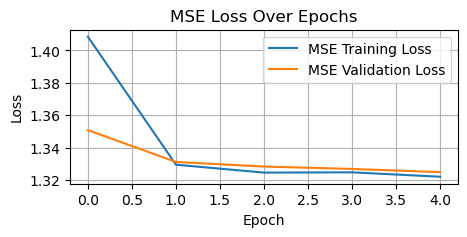

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
IN_CHANNELS = 1
OUT_CHANNELS = 1
NUM_EPOCHS = 5


hyperparameter_settings = {
    'learning_rates': [1e-3, 1e-4, 1e-5],
    'weight_decays': [1e-5, 1e-6, 1e-7],
    'encoder_depths': [3, 4, 5],
    'decoder_channels_options': [(256, 128, 64), (128, 64, 32, 16), (128, 64, 32, 16, 8)]
}

loss_functions_config = {
    "MSE": nn.MSELoss,
    "L1": nn.L1Loss,
    "SmoothL1": nn.SmoothL1Loss
}

output_dir = "training_run_results"
os.makedirs(output_dir, exist_ok=True)

def train_one_epoch(loader, model, optimizer, loss_fn, device, scaler):
    model.train()
    epoch_loss = 0
    if loader is None: return 0.0

    for batch_idx, (noisy1, noisy2, _c, _ts, _cn) in enumerate(loader):
        noisy1, noisy2 = noisy1.to(device), noisy2.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            denoised_output = model(noisy1)
            loss = loss_fn(denoised_output, noisy2)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        if batch_idx % 10 == 0: print(f"Tr B {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")

    avg_epoch_loss = epoch_loss / len(loader) if len(loader) > 0 else 0.0
    print(f"End Epoch Train Avg Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

def validate_one_epoch(loader, model, loss_fn, device):
    model.eval()
    epoch_loss = 0
    if loader is None: return float('inf')

    with torch.no_grad():
        for noisy1, noisy2, _c, _ts, _cn in loader:
            noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                denoised_output = model(noisy1)
                loss = loss_fn(denoised_output, noisy2)
            epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader) if len(loader) > 0 else float('inf')
    print(f"Val Avg Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

print("\nStarting hyperparameter tuning...")

if 'train_loader' not in globals() or train_loader is None:
    print("Training cannot proceed: train_loader is None or not defined in global scope.")
else:
    param_value_lists = [
        hyperparameter_settings['learning_rates'],
        hyperparameter_settings['weight_decays'],
        hyperparameter_settings['encoder_depths'],
        hyperparameter_settings['decoder_channels_options']
    ]

    for loss_name, LossClass in loss_functions_config.items():
        for combo_values in product(*param_value_lists):
            current_lr, current_wd, current_ed, current_dc = combo_values

            combo_id_parts = [
                f"LR_{current_lr}",
                f"WD_{current_wd}",
                f"ED_{current_ed}",
                f"DC_{'_'.join(map(str, current_dc))}",
                f"LOSS_{loss_name}"
            ]
            combo_id = "_".join(combo_id_parts)
            print(f"\n\n{'='*10} Starting Run for Combination: {combo_id} {'='*10}")

            model = smp.Unet(
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHTS,
                encoder_depth=current_ed,
                decoder_channels=current_dc,
                in_channels=IN_CHANNELS,
                classes=OUT_CHANNELS,
            ).to(DEVICE)

            criterion = LossClass().to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

            train_losses_for_combo, val_losses_for_combo = [], []
            best_val_loss_for_combo = float('inf')
            best_model_state_for_combo = None

            print(f"\nStarting training for {combo_id}...")
            for epoch in range(NUM_EPOCHS):
                print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} for {combo_id} ---")
                train_loss = train_one_epoch(train_loader, model, optimizer, criterion, DEVICE, scaler)
                train_losses_for_combo.append(train_loss)

                current_epoch_val_loss = float('inf')
                if 'val_loader' in globals() and val_loader is not None:
                    current_epoch_val_loss = validate_one_epoch(val_loader, model, criterion, DEVICE)
                    val_losses_for_combo.append(current_epoch_val_loss)

                    if current_epoch_val_loss < best_val_loss_for_combo:
                        best_val_loss_for_combo = current_epoch_val_loss
                        best_model_state_for_combo = model.state_dict()
                        print(f"New best validation loss for {combo_id}: {best_val_loss_for_combo:.4f} at epoch {epoch+1}")
                else:
                    # If no val_loader, we can't save based on "best validation loss"
                    # This combination will not save a model based on validation.
                    # We will still save its training loss plot.
                    pass
            
            print(f"\nTraining finished for {combo_id}!")

            if best_model_state_for_combo is not None and 'val_loader' in globals() and val_loader is not None:
                model_save_path = os.path.join(output_dir, f"best_model_{combo_id}.pth")
                torch.save(best_model_state_for_combo, model_save_path)
                print(f"Saved best model for {combo_id} to {model_save_path} (Val Loss: {best_val_loss_for_combo:.4f})")
            elif 'val_loader' in globals() and val_loader is not None:
                print(f"No improvement in validation loss for {combo_id}. Best model not saved.")
            else:
                print(f"No validation loader provided for {combo_id}. Best model not saved.")


            if train_losses_for_combo or val_losses_for_combo:
                plt.figure(figsize=(6,3))
                if train_losses_for_combo:
                    plt.plot(train_losses_for_combo, label=f"Training Loss ({loss_name})")
                if val_losses_for_combo:
                    plt.plot(val_losses_for_combo, label=f"Validation Loss ({loss_name})")
                
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                title_str = f"Loss Over Epochs - {combo_id}"
                plt.title(title_str.replace('_', ' '))
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plot_save_path = os.path.join(output_dir, f"loss_plot_{combo_id}.png")
                plt.savefig(plot_save_path)
                plt.close()
                print(f"Saved loss plot for {combo_id} to {plot_save_path}")

print("\nAll hyperparameter tuning runs finished!")


Loading best validation model for display from: best_denoising_model_mse_loss.pth

Displaying results from Test Set...


/scratch/local/4428790/ipykernel_1388747/606274776.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


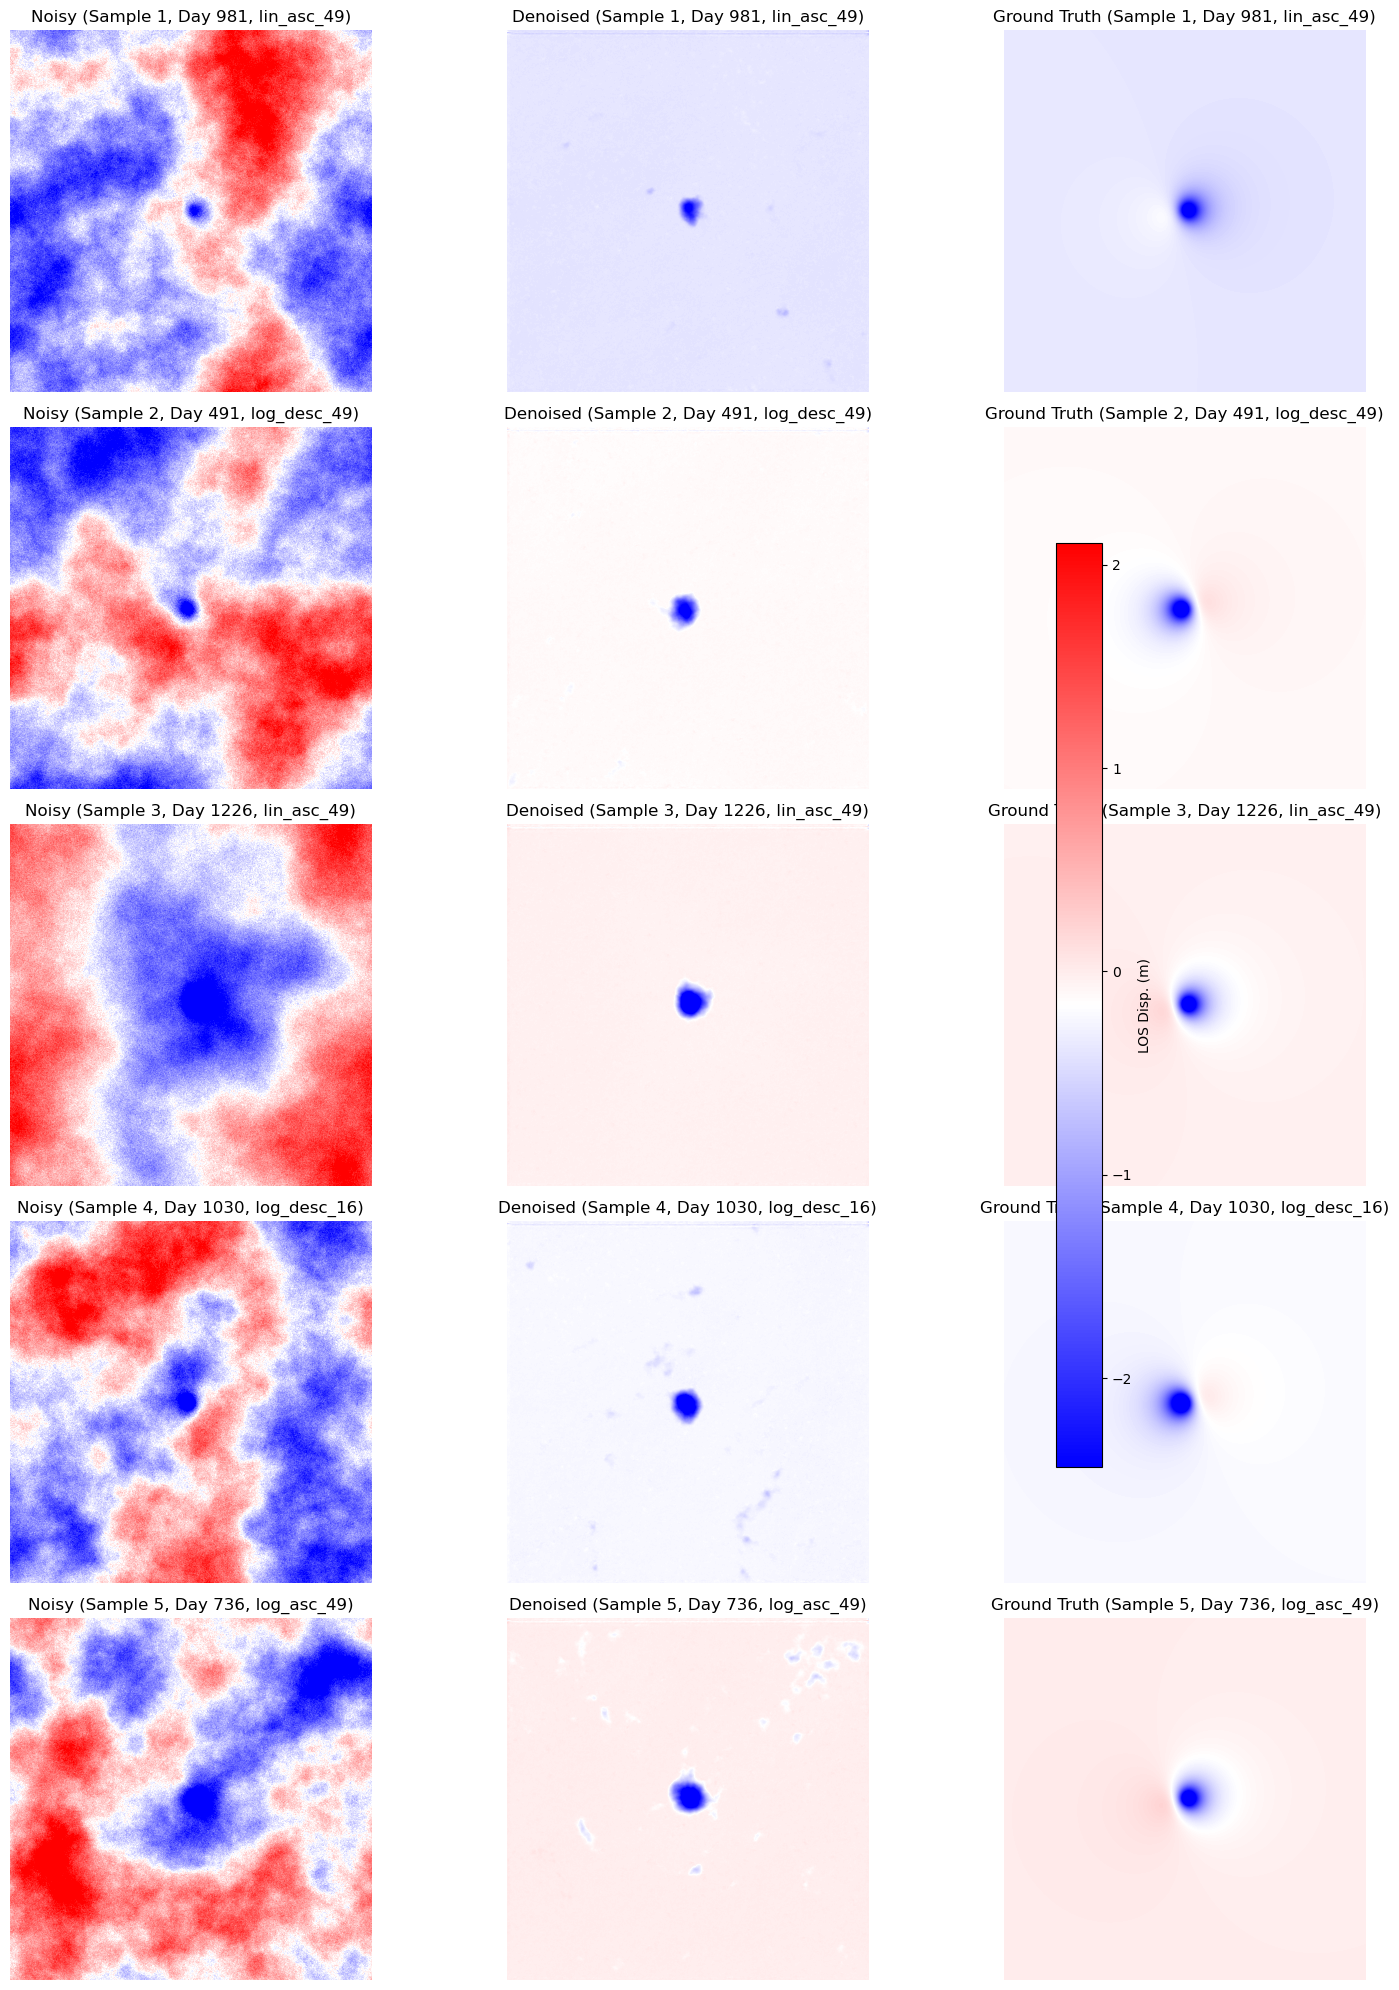

In [5]:
def display_results(model, data_loader, device, num_samples=5):

    model.eval().to(device)
    data_iter = iter(data_loader) 

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    if num_samples == 1: 
        axes = np.array([axes])

    with torch.no_grad():
        for i in range(num_samples):
            try:
                noisy_input, _, ground_truth, time_steps, config_names = next(data_iter)
                time_step = time_steps[0] if isinstance(time_steps, (list, torch.Tensor)) else time_steps
                config_name = config_names[0] if isinstance(config_names, list) else config_names
            except StopIteration: 
                print("Not enough samples in the data_loader to display the requested num_samples.")
                break

            noisy_input = noisy_input.to(device)
            single_noisy_input = noisy_input[0:1]
            single_ground_truth = ground_truth[0].cpu().numpy().squeeze()
            denoised_output = model(single_noisy_input)
            single_denoised_output = denoised_output[0].cpu().numpy().squeeze()
            single_noisy_input_np = single_noisy_input[0].cpu().numpy().squeeze()

            all_vals = np.concatenate([
                single_noisy_input_np.ravel(), single_denoised_output.ravel(), single_ground_truth.ravel()
            ])
            vmin = np.percentile(all_vals, 1) 
            vmax = np.percentile(all_vals, 99)
            if vmin >= vmax: vmin, vmax = all_vals.min(), all_vals.max()
            if vmin == vmax: vmin -= 0.1; vmax += 0.1 
            
            base_title = f"(Sample {i+1}, Day {time_step}, {config_name})"
            axes[i,0].set_title(f"Noisy {base_title}")
            axes[i,0].axis('off')
            im = axes[i,0].imshow(single_noisy_input_np,cmap='bwr',vmin=vmin,vmax=vmax)
            
            axes[i,1].set_title(f"Denoised {base_title}")
            axes[i,1].axis('off')
            im_denoised = axes[i,1].imshow(single_denoised_output,cmap='bwr',vmin=vmin,vmax=vmax) 
            
            axes[i,2].set_title(f"Ground Truth {base_title}")
            axes[i,2].axis('off')
            im_gt = axes[i,2].imshow(single_ground_truth,cmap='bwr',vmin=vmin,vmax=vmax) 

    if num_samples > 0 and 'im_gt' in locals():
        fig.colorbar(im_gt, ax=axes.ravel().tolist(), shrink=0.6, label='LOS Disp. (m)')
    
    plt.tight_layout()
    plt.show()

model_loaded_for_display = False
best_model_path = "best_denoising_model_mse_loss.pth"
last_epoch_model_path = f"model_epoch_{NUM_EPOCHS}.pth" if 'NUM_EPOCHS' in locals() else None

if os.path.exists(best_model_path):
    print(f"\nLoading best validation model for display from: {best_model_path}")
    try:
        model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
        model_loaded_for_display = True
    except Exception as e:
        print(f"Error loading best model: {e}")
elif last_epoch_model_path and os.path.exists(last_epoch_model_path):
    print(f"\nBest validation model not found. Loading model from last epoch: {last_epoch_model_path}")
    try:
        model.load_state_dict(torch.load(last_epoch_model_path, map_location=DEVICE))
        model_loaded_for_display = True
    except Exception as e:
        print(f"Error loading last epoch model: {e}")
else:
    print("\nNo saved model weights found (checked for 'best_denoising_model.pth' and last epoch model).")
    print("Using current model state for display (if any training was done in this session).")
    if 'NUM_EPOCHS' in locals() and NUM_EPOCHS > 0 :
         model_loaded_for_display = True 
    elif 'NUM_EPOCHS' in locals() and NUM_EPOCHS == 0:
         model_loaded_for_display = True

should_display = model_loaded_for_display or ('NUM_EPOCHS' in locals() and NUM_EPOCHS == 0)

if should_display:
    if test_loader is not None and len(test_loader) > 0:
        print("\nDisplaying results from Test Set...")
        display_results(model, test_loader, DEVICE)
    elif val_loader is not None and len(val_loader) > 0:
        print("\nTest Set empty or unavailable. Displaying results from Validation Set...")
        display_results(model, val_loader, DEVICE)
    elif train_loader is not None and len(train_loader) > 0:
        print("\nTest and Validation Sets empty or unavailable. Displaying results from Training Set...")
        display_results(model, train_loader, DEVICE)
    else:
        print("All data loaders are empty. Cannot display results.")
else:
    print("\nModel not loaded and no conditions met to display results.")